# On Questions Relating to Socioeconomic Data in Albany NY

*Special Note: All simulations have been reduced to 10 or 100 trials each.  Running this notebook's simulations with such low trial counts provides you with very fast simulations, but statistically insignificant results.  For any given simulation you'll need on the order of one to ten thousand trials for a given feature set to determine the significance of the determined average accuracy.  On these orders of magnitude the simulations can take days to weeks to complete.  Hence, the reduction to 10 or 100 trials.*

## Data
Census/Walk Data: (contained in the Dataset.csv file)
* https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/WQ2M1H

Neighborhood maps and Census/Walk Data Source:
* https://statisticalatlas.com/place/New-York/Albany/Overview

HOLC Grading Data: (labels from the 1935-1940 HOLC grading of albany districts at the time.  Meticulous inspection of the 1940s neighborhood map and the current neighborhood map was performed to obtain the modern neighborhood gradings by hand.)
* https://dsl.richmond.edu/panorama/redlining/#loc=16/42.656/-73.799&maps=0&city=albany-ny 

Free Food Fridge Data: (data taken by hand from neighborhood maps and fridge locations)
* https://freefoodfridgealbany.com/

## Classification Problems
The standing classification problems are, 
* "Are there modern features in this dataset which correlate with the HOLC gradings from 1935-1940?", and, 
* "Are there modern features which classify the neighborhoods which contain free food fridges?"

## Prediction from Classifiers
Furthermore, a prediction and suggestion problem is apparent.  
* For neighborhoods which were not graded in the 1930s, what would their grade be based on our classifier? 
* For neighborhoods which do not have a free food fridge, which would our classifier predict would have one?

## Initial Thoughts
Features related to education, income, diversity, and population density might be good starting places.

# Importing of Necessary Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MaxAbsScaler


## Constructing Initial Dataframe from Census/Walk Dataset

In [2]:
dataFrame = pd.read_csv("Dataset.csv")

## Constructing the Dataframe with Selected Features
Not all 110 features are of initial interest.  Only the following features will be used.

Upon inspection, there are very little data on the neighborhoods Pastures and West End beyond basic census data.  They will not be used for several fits and tests later on.

Walk/Bike/Transit scores for Eagle Hill need to be filled in.  After inspecting the neighborhood maps, Eagle Hill is the southern portion of "Campus/University" district.  Hence, I will use WalkScore's ratings for the campus area.  These are walk score 35, transit score 45, and bike score 33.  These changes were made to the .csv file and were not done within this python notebook.

Job Sector features include many missing datapoints.  Without knowledge of unemployed persons, these missing data cannot be imputed.  Therefore, these features should be skipped in any analysis.

In [3]:
#An initial dataframe with all of the possibly pertinent features.

dfFullOLD = dataFrame[['nei_final_simple','walk_score','transit_score','bike_score','population',
           'population_density','household_income','marital_status_married','marital_status_separated_divorce',
           'marital_status_widowed','marital_status_never_married','white_popl',
            'hispanic_popl','black_popl','asian_popl','mixed_popl','other_popl','food_stamps_total',
            'educational_attainment_no_hs','educational_attainment_bachelors','educational_attainment_very_advanced_degrees',
            'private_sector','self_employed_sector','non_profit_sector','household_type_married_count',
            'household_type_single_female_count','household_type_single_male_count','household_type_one_person_count',
            'household_type_other_non_family_count','household_type_with_children','Age_0_to_17','Age_18_to_21',
            'Age_22_to_29','Age_30_to_39','Age_40_to_49','Age_50_to_59','Age_60_to_69','Age_70_to_79','Age_80_older']]

fullfeaturelist = ['nei_final_simple','walk_score','transit_score','bike_score','population',
           'population_density','household_income','marital_status_married','marital_status_separated_divorce',
           'marital_status_widowed','marital_status_never_married','white_popl',
            'hispanic_popl','black_popl','asian_popl','mixed_popl','other_popl','food_stamps_total',
            'educational_attainment_no_hs','educational_attainment_bachelors','educational_attainment_very_advanced_degrees',
            'household_type_married_count', 'household_type_single_female_count',
            'household_type_single_male_count','household_type_one_person_count',
            'household_type_other_non_family_count','household_type_with_children','Age_0_to_17','Age_18_to_21',
            'Age_22_to_29','Age_30_to_39','Age_40_to_49','Age_50_to_59','Age_60_to_69','Age_70_to_79','Age_80_older']

featurelist = fullfeaturelist[1:]

# A new dataframe after removing job sector data since much of this is missing across many neighborhoods.
dfFull = dataFrame[fullfeaturelist]

# Taking out Pastures Neighborhood because of large lack of data.
df = pd.DataFrame(dfFull[dfFull['nei_final_simple']!= 'Pastures'],columns = fullfeaturelist)
# Taking out West End Neighborhood because of large lack of data.
df = pd.DataFrame(df[df['nei_final_simple'] != 'West End'],columns = fullfeaturelist)
df.reset_index(drop = True, inplace=True)


## Normalizing the Dataframe

In [4]:
scaler = MaxAbsScaler()
scaler.fit(df[featurelist])
scaledData = scaler.transform(df[featurelist])
dfScaled = pd.DataFrame(scaledData,columns=featurelist)
dfScaled['nei_final_simple']=df['nei_final_simple']

## Adding Labels from the 1935-1940 HOLC Grading
Several neighborhoods did not exist or were not graded in the 1930s.  These were Dunes, Campus District, Normanskill,Bishop's Gate, Downtown, Central Avenue, Center Square, and Manning Blvd: those Manning Blvd may be the Lancaster neighborhood by another name. While these were not graded, I will attempt to find an accurate classifier for HOLC grades from the contemporary data and then use the available data to predict an '1930s HOLC Grade' for each.

HOLC Grade Numerization A = 0, B = 1, C = 2, D = 3, Not Graded/Didn't Exist in 1930s = 4. 

Some neighborhoods are not subsets of the 1930s neighborhoods.  In these cases, the average HOLC grade is given unless the average is not a whole number.  In this case, the decimal is truncated for the label.  
* Modern Pine Hills was roughly half B and half C. (avg is 1.5, labelled 1)
* Modern Lancaster was roughly half A and half B. (Not listed in Census Data)
* Modern Deleware Ave is 1/3 A, B, and C. (avg is 1, labelled 1)
* Modern 2nd Ave was roughly half C and D. (avg is 2.5, labelled 2)

Eagle Hill (C, index 9) and Pastures (D, index 19) gradings 

In [5]:
# Labels WITH Eagle Hill and Pastures included.
#df.loc[:,'holc_grade'] = pd.Series(np.array([3,1,4,0,4,4,1,4,4,2,1,3,4,3,0,1,4,2,2,3,1,2,3,3,0,3,3,0]),index=df.index)
# Labels WITHOUT Eagle Hill and Pastures included.
df.loc[:,'holc_grade'] = pd.Series(np.array([3,1,4,0,4,4,1,4,4,1,3,4,3,0,1,4,2,2,1,2,3,3,0,3,3,0]),index=df.index)
dfScaled.loc[:,'holc_grade'] = pd.Series(np.array([3,1,4,0,4,4,1,4,4,1,3,4,3,0,1,4,2,2,1,2,3,3,0,3,3,0]),index=dfScaled.index)

## Free Food Fridge Locations and Neighborhoods in Albany
These are listed as FRIDGE NAME Address (Neighborhood(s) - HOLC Grade(s))
* THE FREE SCHOOL 8 Elm Street, Albany, NY (Mansion District - D)
* IN OUR OWN VOICES 245 Lark St, Albany, NY (Center Square - Not Graded)
* ALBANY CENTER GALLERY 488 Broadway, Albany NY (Downtown - Not Graded)
* RADIX ECOLOGICAL SUSTAINABILITY CENTER 153 Grand Street, Albany NY (Mansion District - D)
* ALBANY BARN 56 2nd Street, Albany, NY (Arbor Hill - D)
* BOYS AND GIRLS CLUB OF THE GREATER CAPITAL REGION 21 Delware Ave, Albany (On border of Park South and Hudson - C & D)

It's interesting to see where these are.  They're almost entirely in neighborhoods rated 'D' by the HOLC or in neighborhoods which were not graded. I'm very curious to see if an accurate HOLC grade classifier would grade these ungraded neighborhoods with free food fridges as C or D.

## Adding Fridge Count to Dataframe
We will add a 'fridge count' column to encode the number of free food fridges in our neighborhoods. While the Deleware Ave is right on the boundary of Park South and Hudson, it is technically in Park South.  Though, in any analysis it might be wise to remember that it might be included in either (or in both).

In [6]:
# Labels WITH Eagle Hill and Pastures included.
#df.loc[:,'fridge_count'] = pd.Series(np.array([1,0,0,0,1,0,0,1,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,]),index=df.index)
# Labels WITHOUT Eagle Hill and Pastures included.
df.loc[:,'fridge_count'] = pd.Series(np.array([1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0]),index=df.index)
dfScaled.loc[:,'fridge_count'] = pd.Series(np.array([1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0]),index=dfScaled.index)

## Inspecting Features for Possible Classifiers

Just something of note, these pairplots took about 15 minutes to produce on my laptop (8 Core AMD Ryzen 7 5700U at 4GHz w/ 16 GB 3200MHz RAM).  The RAM was never saturated, so disk swapping never occured.  Additionally, it looks as though Seaborn does not parallelize the plotting as only one of my cores was ever used heavily (~100%).  Hence, the images have been saved and are viewed by loading the images with IPython.

In [7]:
from IPython.display import Image
import seaborn as sns

In [8]:
#Code to generate the pairplot.  If the image is not locally stored, run this code instead of loading the image.
#sns_plot = sns.pairplot(df[['walk_score','transit_score','bike_score','population',
#           'population_density','household_income','marital_status_married','marital_status_separated_divorce',
#           'marital_status_widowed','marital_status_never_married','white_popl',
#            'hispanic_popl','black_popl','asian_popl','mixed_popl','other_popl','food_stamps_total',
#            'educational_attainment_no_hs','educational_attainment_bachelors','educational_attainment_very_advanced_degrees',
#            'household_type_married_count', 'household_type_single_female_count',
#            'household_type_single_male_count','household_type_one_person_count',
#            'household_type_other_non_family_count','household_type_with_children','Age_0_to_17','Age_18_to_21',
#            'Age_22_to_29','Age_30_to_39','Age_40_to_49','Age_50_to_59','Age_60_to_69','Age_70_to_79','Age_80_older','holc_grade']],hue='holc_grade',diag_kind='kde')
#sns_plot.savefig("pairplot.png")
#Image("pairplot.png")

In [9]:
#Code to generate the pairplot.  If the image is not locally stored, run this code instead of loading the image.
#sns_plot_FCt = sns.pairplot(df[['walk_score','transit_score','bike_score','population',
#           'population_density','household_income','marital_status_married','marital_status_separated_divorce',
#           'marital_status_widowed','marital_status_never_married','white_popl',
#            'hispanic_popl','black_popl','asian_popl','mixed_popl','other_popl','food_stamps_total',
#            'educational_attainment_no_hs','educational_attainment_bachelors','educational_attainment_very_advanced_degrees',
#            'household_type_married_count', 'household_type_single_female_count',
#            'household_type_single_male_count','household_type_one_person_count',
#            'household_type_other_non_family_count','household_type_with_children','Age_0_to_17','Age_18_to_21',
#            'Age_22_to_29','Age_30_to_39','Age_40_to_49','Age_50_to_59','Age_60_to_69','Age_70_to_79','Age_80_older','fridge_count']],hue='fridge_count',diag_kind='kde')
#sns_plot_FCt.savefig("pairplot_FCt.png")

#Image("pairplot_FCt.png")

In [10]:
# An inspection of the correlations between the features
#df[['transit_score','bike_score','household_income','marital_status_married','marital_status_widowed','Age_80_older','household_type_married_count','fridge_count']].corr()

Possible features for HOLC Grade Classification
* +Correlation: 'other_popl' (0.269),
* -Correlation: 'asian_popl' (-.274), household_type_married_count (-.309), marital_status_married (-.289), marital_status_separated_divorce (-.267), Age_40_to_49 (-.388), Age_60_to_69 (-.267), Age_70_to_79 (-.331)

Possible features for Fridge Location Classification
* +Correlation: transit_score (.257), bike_score (.298)
* -Correlation: household_income (-.278), marital_status_married (-.253), marital_status_widowed (-.325), Age_70_to_79 (-.278), Age_80_older (-.252), household_type_married_count (-.270), 

In [11]:
#'marital_status_separated_divorce' is causing issues...
#sns_plot_NegCorr = sns.pairplot(df[['asian_popl','household_type_married_count','marital_status_married','marital_status_separated_divorce','Age_40_to_49','Age_60_to_69','Age_70_to_79','holc_grade']],hue='holc_grade',diag_kind='kde')
#sns_plot_NegCorr.savefig("pairplot_NegCorr.png")
#Image("pairplot_NegCorr.png")

In [12]:
#sns_plot_FCt_NegCorr = sns.pairplot(df[['household_income','marital_status_married',
#           'marital_status_widowed','Age_70_to_79','Age_80_older','household_type_married_count','fridge_count']],hue='fridge_count',diag_kind='kde')
#sns_plot_FCt_NegCorr.savefig("pairplot_FCt_NegCorr.png")
#Image("pairplot_FCt_NegCorr.png")

## Discussion on Train and Test Split of Data for Classifiers

### HOLC Train and Test
For these data we can only select neighborhoods which have been graded.  I.e. we need to select only neighborhoods without a '4' in their holc grade column. This leaves us with only 19 samples.

### A Single Free Food Fridge Train and Test Accuracy Check
All the data are available for this train and test split.  This gives us 26 samples.

In [13]:
# A data frame of HOLC graded neighborhoods.
dfGraded = df[df['holc_grade']<4]

In [14]:
trainFood, testFood = train_test_split(df, test_size = 0.2,random_state = 0)
foodNegCorrFeatures = ['transit_score','bike_score','household_income','marital_status_widowed','Age_80_older','household_type_married_count']

# A quick check to see if any single feature classifies the fridge_count labels or not.  The answer is, no.  
predictions = []
for key in foodNegCorrFeatures:
    accuracylist = []
    for i in range(1,5):
        neighFridge = KNeighborsClassifier(n_neighbors = i)
        neighFridge.fit(np.array(trainFood[key]).reshape(-1,1), trainFood['fridge_count'])
        pred = neighFridge.predict(np.array(testFood[key]).reshape(-1,1))
        accuracy = round(sum([1 for i in range(len(pred)) if pred[i] == np.array(testFood['fridge_count'])[i]])/len(pred),3)
        accuracylist.append(accuracy)
    predictions.append({key:accuracylist})
predictions

[{'transit_score': [0.833, 0.833, 0.833, 0.833]},
 {'bike_score': [0.833, 0.833, 0.833, 0.833]},
 {'household_income': [0.833, 0.667, 0.667, 0.833]},
 {'marital_status_widowed': [0.667, 0.833, 0.667, 0.667]},
 {'Age_80_older': [0.833, 0.833, 1.0, 0.833]},
 {'household_type_married_count': [0.5, 0.667, 0.667, 0.833]}]

In [15]:
trainFood, testFood = train_test_split(df, test_size = 0.2,random_state = 0)
# How about all of the features...
accuracylist = []
for i in range(1,5):
    neighFridge = KNeighborsClassifier(n_neighbors = i)
    neighFridge.fit(trainFood[foodNegCorrFeatures], trainFood['fridge_count'])
    pred = neighFridge.predict(testFood[foodNegCorrFeatures])
    accuracy = round(sum([1 for i in range(len(pred)) if pred[i] == np.array(testFood['fridge_count'])[i]])/len(pred),3)
    accuracylist.append(accuracy)
accuracylist

[0.833, 0.667, 0.667, 0.833]

## Simulating KNN and Optimizing Parameters
In order to get a good idea of which features are best for classifying the free food fridge locations, the following code removes the variety produced by either selecting 'random_state = 0' or by letting any state be chosen at random.  These methods instead run $N$ trials of KNN with randomly reselected train-test splits for each trial and returns average accuracies for a given range of k (k_min to k_max).  Passing these accuracies into the central limit theorem allows us to make statements about confidence intervals for the average accuracies. (i.e. Is our KNN classifier more/less accurate than a naive guess?)


- Fixing the feature list and k_max values and varying the train-test split can help pick an optimal split.
- Fixing the train-test split and k_max values and varying the feature list can help pick optimal features.
- Running all variations over some range of k_max can help select the optimal k value.
- With 21 neighborhoods without fridges and 5 with, a lazy "always no fridge" classification would score an accuracy of 21/26 = 0.80769
 

In [16]:
def getAccuracy(features, trainData, testData,k_max = 5,label = 'fridge_count',k_min = 1):
    '''Given a list of features from a train-test split from a data frame
    this method returns the classification accuracy of a KNN method for 
    all values of k up to k_max.  Assumes features is a list of column
    names from the data frame from which trainData and testData were 
    contrived.  trainData and testData must have a column titled "fridge_count"
    or a given label must be supplied for target labels.'''
    accuracylist = []
    for i in range(k_min,k_max):
        neighFridge = KNeighborsClassifier(n_neighbors = i)
        neighFridge.fit(trainData[features], trainData[label])
        pred = neighFridge.predict(testData[features])
        accuracy = round(sum([1 for i in range(len(pred)) if pred[i] == np.array(testData[label])[i]])/len(pred),3)
        accuracylist.append(accuracy)
    return np.array(accuracylist)

def getAvgAccuracyNTrials(features,data,trials = 100,split_size = 0.2,k_max = 5,label = 'fridge_count',k_min=1):
    '''Given a list of features, a data frame, a size of train-test split (0,1),
    and a k_max value, this method runs trials of knn and returns an average
    accuracy list for all values of k from 1 to k_max.'''
    accuracyList = []
    for i in range(trials):
        trainFood, testFood = train_test_split(data, test_size = split_size)
        accuracyList.append(getAccuracy(features,trainFood,testFood,k_max,label,k_min))
    avgArray = np.zeros(len(accuracyList[0]))
    for array in accuracyList:
        avgArray = avgArray + array
    return avgArray/trials

def getClassResults(features,data,trials = 100,split_size = 0.2, k= 1, label = 'fridge_count'):
    '''Given a list of features, a data frame, a size of train-test split (0,1),
    and a k value, this returns essentially a confusion matrix.'''
    # guess is correct, truth of neighborhood having fridge
    correctHasFridge = 0
    incorrectNoFridge = 0
    correctNoFridge = 0
    incorrectHasFridge = 0
    for i in range(trials):
        trainFood, testFood = train_test_split(data, test_size = split_size)
        neighFridge = KNeighborsClassifier(n_neighbors = k)
        neighFridge.fit(trainFood[features], trainFood[label])
        pred = neighFridge.predict(testFood[features])
        for j in range(len(pred)):
            if pred[j] == 1:
                if pred[j] == np.array(testFood[label])[j]:
                    correctHasFridge = correctHasFridge + 1
                else: 
                    incorrectNoFridge = incorrectNoFridge + 1
            else:
                if pred[j] == np.array(testFood[label])[j]:
                    correctNoFridge = correctNoFridge + 1
                else:
                    incorrectHasFridge = incorrectHasFridge + 1            
        
    return np.array([[correctHasFridge,incorrectNoFridge],[incorrectHasFridge,correctNoFridge]])

def getCI(p,N,z=1.96):
    '''A method for determining the confindence interval (CI) for a given accuracy value p.
    When an accuracy of p* has been found after running N simulations, we wish to know the CI 
    to determine if p* is statistically significant, or if it was caused by variations within 
    our resampling. N is the number of times you have rerun your simulations.  p is the average
    accuracy of your simulations.  z is the t-value with N-1 DF or the z-value for sufficiently high
    DFs.  i.e. for very large samples you can use z = 1.96 for a 95% CI.'''
    interval = z*(np.sqrt(p*(1-p)/N))
    return np.array([p-interval,p+interval])

In [17]:
print("Confusion Matrix")
print(getClassResults(['bike_score','population_density','household_income'],dfScaled,trials = 100,k= 3))

Confusion Matrix
[[ 35   7]
 [ 72 486]]


### Passing Class Results Into Heat Maps for Confusion Matrices


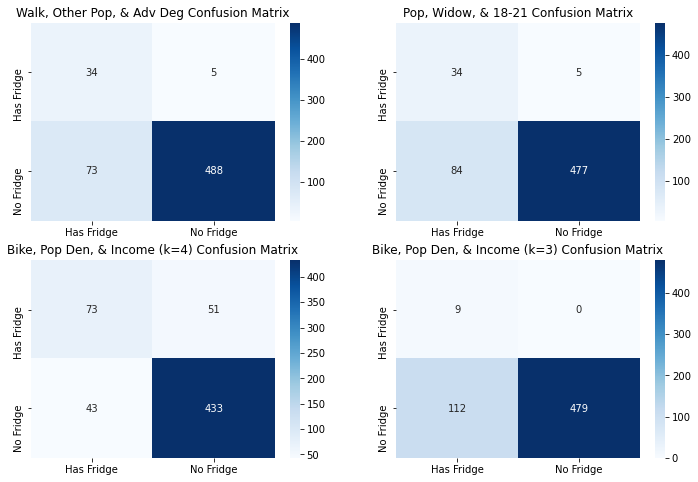

In [19]:
cm0 = pd.DataFrame(getClassResults(['bike_score','population_density','household_income'],
                    dfScaled,trials = 100,k= 3), ['Has Fridge','No Fridge'] ,['Has Fridge','No Fridge'])
cm1 = pd.DataFrame(getClassResults(['walk_score','other_popl','educational_attainment_very_advanced_degrees'],
                    dfScaled,trials = 100,k= 2),['Has Fridge','No Fridge'] ,['Has Fridge','No Fridge'])
cm2 = pd.DataFrame(getClassResults(['population','marital_status_widowed','Age_18_to_21'],
                    dfScaled,trials = 100,k= 1),['Has Fridge','No Fridge'] ,['Has Fridge','No Fridge'])
cm3 = pd.DataFrame(getClassResults(['bike_score','population_density','household_income'],
                    dfScaled,trials = 100,k= 4),['Has Fridge','No Fridge'] ,['Has Fridge','No Fridge'])

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2,figsize = (12,8))
sns.heatmap(cm0, annot=True,cmap='Blues', fmt='d',ax=ax0) 
ax0.set_title("Walk, Other Pop, & Adv Deg Confusion Matrix")

sns.heatmap(cm1, annot=True,cmap='Blues', fmt='d',ax=ax1) 
ax1.set_title("Pop, Widow, & 18-21 Confusion Matrix")

sns.heatmap(cm2, annot=True,cmap='Blues', fmt='d',ax=ax2) 
ax2.set_title("Bike, Pop Den, & Income (k=4) Confusion Matrix")

sns.heatmap(cm3, annot=True,cmap='Blues', fmt='d',ax=ax3) 
ax3.set_title("Bike, Pop Den, & Income (k=3) Confusion Matrix")

plt.show()

### Simulating KNN for K=1,...,7 on All Features, 10000 Trials
- getAvgAccuracyNTrials(featurelist, dfScaled,trials = 10000,k_max = 8) yields:
-[0.7466684, 0.8001966, 0.77983  , 0.787979 , 0.7866636, 0.8066917,0.8066583]

No accuracy has a confidence interval of significance which suggests these features are more accurate classifiers than naively guessing 'no fridge in this neighborhood' for all neighborhoods.

In [20]:
getAvgAccuracyNTrials(['marital_status_widowed'], dfScaled,trials = 100,k_max = 6)

array([0.8299 , 0.78161, 0.73336, 0.80491, 0.77159])

### Simulating KNN for K=1,...,7 on Negatively Correlated Features, 10000 Trials
- getAvgAccuracyNTrials(foodNegCorrFeatures, dfScaled,trials = 10000,k_max = 8) yields:
-[0.7281158, 0.7986387, 0.7375997, 0.8062174, 0.7935102, 0.8040666,0.7880569]

No accuracy has a confidence level which suggests these features are more accurate classifiers than naively guessing 'no fridge in this neighborhood' for all neighborhoods.

In [21]:
foodNegCorrFeatures = ['transit_score','bike_score','household_income','marital_status_widowed','Age_80_older','household_type_married_count']
getAvgAccuracyNTrials(foodNegCorrFeatures, dfScaled,trials = 100,k_max = 8)

array([0.71171, 0.77997, 0.72004, 0.7833 , 0.77498, 0.78496, 0.76664])

# Single Feature Classifier Accuracies

In [22]:
for feature in featurelist:
    print("Feature: "+feature+" Accuracy (k = index+1): " + str(getAvgAccuracyNTrials([feature],dfScaled,trials=100,k_max=8)))

Feature: walk_score Accuracy (k = index+1): [0.65336 0.75493 0.71168 0.79325 0.79325 0.79325 0.79325]
Feature: transit_score Accuracy (k = index+1): [0.6167  0.78829 0.73164 0.79495 0.78496 0.79828 0.79828]
Feature: bike_score Accuracy (k = index+1): [0.73001 0.78996 0.74833 0.79663 0.79663 0.79663 0.79663]
Feature: population Accuracy (k = index+1): [0.69837 0.77492 0.74663 0.80324 0.80324 0.80324 0.80324]
Feature: population_density Accuracy (k = index+1): [0.67841 0.76167 0.69173 0.80829 0.80829 0.80829 0.80829]
Feature: household_income Accuracy (k = index+1): [0.66004 0.74998 0.75162 0.78659 0.78659 0.81158 0.81158]
Feature: marital_status_married Accuracy (k = index+1): [0.61173 0.75001 0.68176 0.78663 0.75499 0.79828 0.79828]
Feature: marital_status_separated_divorce Accuracy (k = index+1): [0.65006 0.7716  0.71331 0.80661 0.7666  0.82327 0.82327]
Feature: marital_status_widowed Accuracy (k = index+1): [0.80157 0.76665 0.73333 0.79826 0.77493 0.79993 0.78325]
Feature: marital_st

## Computing Confidence Intervals for a given list of Accuracies from a list of Features

In [23]:
trils = 100
cLevel = 2
possFeatures =['marital_status_widowed']

for feature in possFeatures:
    accuracies = getAvgAccuracyNTrials([feature],df,trials=trils,k_max=8)
    print("Feature: "+feature+" Accuracy (k = index+1): " + str(accuracies))
    print("CI: "+str([getCI(accuracy,trils,cLevel) for accuracy in accuracies]))

Feature: marital_status_widowed Accuracy (k = index+1): [0.82158 0.77996 0.72665 0.81659 0.77161 0.80824 0.78494]
CI: [array([0.74500682, 0.89815318]), array([0.69710533, 0.86281467]), array([0.6375142, 0.8157858]), array([0.73918954, 0.89399046]), array([0.68765096, 0.85556904]), array([0.72950294, 0.88697706]), array([0.70276721, 0.86711279])]


## Checking various split sizes for improvements to accuracy

In [24]:
for x in [i/20 for i in range(1,14)]:
    print("Split size: " + str(x) + str(getAvgAccuracyNTrials(foodNegCorrFeatures, df,trials = 100,split_size = x,k_max = 8)))

Split size: 0.05[0.685 0.75  0.74  0.785 0.785 0.815 0.815]
Split size: 0.1[0.6434  0.71344 0.71344 0.75346 0.75346 0.77346 0.77346]
Split size: 0.15[0.6925 0.7625 0.7775 0.7975 0.7975 0.815  0.815 ]
Split size: 0.2[0.65667 0.75665 0.74497 0.79998 0.79998 0.81164 0.81164]
Split size: 0.25[0.67834 0.7469  0.74119 0.78122 0.78122 0.79409 0.79409]
Split size: 0.3[0.71    0.7625  0.75125 0.8     0.8     0.81625 0.81625]
Split size: 0.35[0.67  0.732 0.73  0.771 0.769 0.783 0.776]
Split size: 0.4[0.69066 0.76068 0.74067 0.80344 0.79889 0.81254 0.80435]
Split size: 0.45[0.69918 0.76827 0.7441  0.79242 0.78825 0.79493 0.78825]
Split size: 0.5[0.70436 0.77593 0.76284 0.80442 0.80057 0.8075  0.80365]
Split size: 0.55[0.71063 0.78195 0.76462 0.81401 0.80266 0.81399 0.80666]
Split size: 0.6[0.7075  0.7742  0.75172 0.79798 0.78296 0.80735 0.79672]
Split size: 0.65[0.68599 0.77495 0.74789 0.79023 0.78024 0.79669 0.78904]


## Confidence Interval for Hopeful Accuracy Values
With random sampling from our data we obtain an accuracy after training and testing.  This process is redone $n$ times to give additional accuracies which are (independent? and) then used to find an average accuracy $a^*$.  From this process we can make a claim such as, We are 95% confident that the accuracy $a$ of our model is within the CI $a^*\pm z \sqrt{(a^*(1-a^*)/n)}$" given some confidence level or z-value.

After initial testing two features appeared to give accuracies higher than the lazy guess of 'always no fridge'.  They were 'educational_attainment_very_advanced_degrees' with $k \geq 4$ and 'marital_status_widowed' with $k = 1$.  Resampling, training, and testing 10,000 times did not confirm the higher accuracies with the first feature (in fact it refuted them), but the latter accuracy was confirmed above a 99% confidence level with a two-tailed test.  Running the process again at 100,000 samples with $k = 1$ for the feature 'marital_status_widowed' gave an accuracy of $a=0.81919396$, which has a 99% confidence interval of $(0.81636347, 0.82202265)$.  

In [25]:
getAvgAccuracyNTrials(['marital_status_widowed'], dfScaled,trials = 10,k_max = 2)

array([0.7833])

In [26]:
# Run this for all pairs with widow feature.
otherFeatures = [feature for feature in featurelist if feature != 'marital_status_widowed']
for feature in otherFeatures:
    print(feature+", accuracies = "+str(getAvgAccuracyNTrials([feature,'marital_status_widowed'],dfScaled,trials = 10,k_max = 8)))

walk_score, accuracies = [0.7    0.7333 0.7166 0.7499 0.7499 0.7499 0.7499]
transit_score, accuracies = [0.8165 0.75   0.6835 0.7666 0.75   0.7832 0.7832]
bike_score, accuracies = [0.6835 0.7666 0.7    0.8166 0.8    0.8166 0.8166]
population, accuracies = [0.8499 0.8333 0.7999 0.8499 0.8499 0.8499 0.8499]
population_density, accuracies = [0.6502 0.7501 0.6501 0.8167 0.7168 0.8167 0.8167]
household_income, accuracies = [0.7    0.7666 0.7666 0.8166 0.7832 0.8333 0.8333]
marital_status_married, accuracies = [0.6166 0.8166 0.7332 0.8499 0.8499 0.8499 0.8499]
marital_status_separated_divorce, accuracies = [0.75   0.8666 0.8666 0.8499 0.8499 0.8499 0.8499]
marital_status_never_married, accuracies = [0.7335 0.8167 0.7833 0.8333 0.8166 0.8333 0.8333]
white_popl, accuracies = [0.7833 0.7832 0.6835 0.8165 0.8165 0.8666 0.8666]
hispanic_popl, accuracies = [0.7    0.7666 0.7165 0.7666 0.6166 0.7666 0.7499]
black_popl, accuracies = [0.65   0.7333 0.7333 0.7666 0.7666 0.7666 0.7666]
asian_popl, accu

In [41]:
def SimAllPairs(df,featurelist,N,k):
    '''An exhaustive search through all pairs of features
    in the featurelist.  This takes on the order of days
    with large enough N to detect significant classifiers.'''
    data = []
    for i in range(len(featurelist)-1):
        for j in range(i+1,len(featurelist)):
            features = [featurelist[i],featurelist[j]]
            accuracies = getAvgAccuracyNTrials(features,df,trials = N,k_max =k)
            data.append([features,accuracies])
    return data

def SimAllTriples(df,featurelist,N,k):
    '''An exhaustive search through all triples of features
    in the featurelist.  This takes on the order of weeks
    with large enough N to detect significant classifiers.'''
    data = []
    for i in range(len(featurelist)-2):
        for j in range(i+1,len(featurelist)-1):
            for p in range(j+1,len(featurelist)):
                features = [featurelist[i],featurelist[j],featurelist[p]]
                accuracies = getAvgAccuracyNTrials(features,df,trials = N,k_max = k)
                data.append([features,accuracies])
    return data

In [42]:
pairsData = SimAllPairs(dfScaled,featurelist,N=10,k=2) # Takes a minute or two with N = 10, but the data will be trash.
triplesData = SimAllTriples(dfScaled,featurelist,N=10,k=2) # Takes a minute or two with N = 10, but the data will be trash.

In [43]:
print("Number of Pairs: ", str(len(pairsData)))
print("Number of Triples: ", str(len(triplesData)))

Number of Pairs:  595
Number of Triples:  6545


## Discussion
There are immediate questions from these results:
1. Why does k-nearest neighbors perform so poorly?
- I would expect similar feature characteristics from neighborhoods containing fridges, but these results suggest that they are quite different in many regards.
2. Are there features which are not in our data which might enable KNN to accurately predict these locations?
- This is a critical question.  How do you measure depravity?
3. Which features of the neighborhoods do the organizers of the Free Food Fridges in Albany program use to decide where to place the fridges?
- In line with the previous comment, perhaps the organizers know more than the data on hand.  Perhaps not.  
4. It is known that census data are incomplete (i.e. not everyone responds).  If the data were complete, would this enable KNN?
- Essentially, are the data missing the vital feature-responses upon which the organizers make their decisions?  Are the vulnerable also those who withhold responses for the census?

## Nesting Dolls
1. It appears that there is a set-subset relation between accurate classifiers on varying levels of sets.  For example, there is only one accuracte single-feature classifier with the feature 'marital_status_widowed'.  This set is a subset of the accurate two-feature classifier feature-set.  Additionally, it appears the set of all accurate two-feature classifier feature-set is a subset of the accurate triple-feature classifier set.  Is this a general phenomenon?  If so, this is an obvious strategy for feature selection in KNN.